In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

from  IPython import display

import numpy as np

import pathlib
import shutil
import tempfile

In [2]:
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
bikes['total'] = bikes.casual + bikes.registered
#bikes['day'] = bikes.dteday.str[:4]
bikes.drop(labels=['dteday', 'casual', 'registered'], axis=1,inplace=True)
bikes.head()

,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,total
0,1,0,0,0,1,0.81,0,3.28,3.0014,16
1,1,1,0,0,1,0.80,0,2.34,1.9982,40
2,1,2,0,0,1,0.80,0,2.34,1.9982,32
3,1,3,0,0,1,0.75,0,3.28,3.0014,13
4,1,4,0,0,1,0.75,0,3.28,3.0014,1


In [3]:
train_dataset = bikes.sample(frac=0.8, random_state=0)
test_dataset = bikes.drop(train_dataset.index)

In [4]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('total')
test_labels = test_features.pop('total')

In [5]:
normalizer = preprocessing.Normalization()

In [6]:
normalizer.adapt(np.array(train_features))

In [7]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 200])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [96]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      normalizer,
      layers.Dense(480, activation='relu'),
      layers.Dense(480, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='huber', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss='huber',
                metrics=[
                  'huber'])

In [97]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_3 (Dense)              (None, 480)               4800      
_________________________________________________________________
dense_4 (Dense)              (None, 480)               230880    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 481       
Total params: 236,180
Trainable params: 236,161
Non-trainable params: 19
_________________________________________________________________


In [98]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=50)

Wall time: 22.5 s


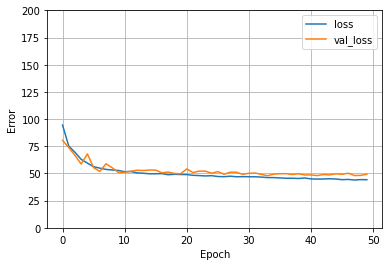

In [99]:
plot_loss(history)

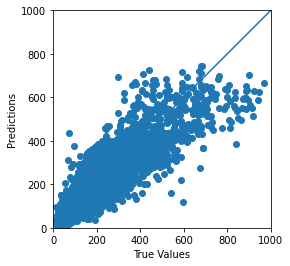

In [31]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [32]:
dnn_model.evaluate(test_features, test_labels)

109/109 [==============================] - 0s 519us/step - loss: 46.9927


46.99273681640625

In [33]:
import kerastuner as kt

In [87]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(normalizer)

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='huber',
                metrics=['mean_absolute_error'])

    return model

In [94]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [95]:
tuner.search(train_features, train_labels, epochs=100, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 48 Complete [00h 00m 03s]
val_loss: 108.07734680175781

Best val_loss So Far: 68.62995147705078
Total elapsed time: 00h 02m 06s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.01.

